# Usage examples of the entrainment_metrics library
The goal of this notebook is to illustrate with a complete example the usage of the two main modules of the `entrainment_metrics` library: `tama` and `continuous`.

We begin with one `.wav` and one `.words` files for each of two speakers, named as follows: `data/test-[AB].{wav,words}`.

The `.words` files are time-aligned transcriptions, with one word per line with following format: `<start> <end> <word>`, where `<start>` and `<end>` are the time boundaries of the interval (expressed in seconds). The special symbol `#` indicates a silent interval. 

See the sample files in the `data/` directory. These files are excerpts taken from the __[UBA Games Corpus](https://ri.conicet.gov.ar/handle/11336/191235)__, a corpus of task-oriented dialogues in Argentine Spanish.

If the transcriptions are at the IPU level (rather than at the word level), the examples within this notebook function identically.

## 1. Extraction of InterPausalUnits
Starting from `.words` files, we may use the `get_interpausal_units` method for getting lists of InterPausalUnits:

In [1]:
from entrainment_metrics import get_interpausal_units, InterPausalUnit
from typing import List

ipusA: List[InterPausalUnit] = get_interpausal_units('data/test-A.words')
ipusB: List[InterPausalUnit] = get_interpausal_units('data/test-B.words')

Let's inspect the first and last elements in each list, keeping in mind that these lists are sorted because the `.words` files are sorted as well:

In [2]:
print(f"First IPU from speaker A: {ipusA[0]}")
print(f"First IPU from speaker B: {ipusB[0]}")
print(f"Last IPU from speaker A: {ipusA[-1]}")
print(f"Last IPU from speaker B: {ipusB[-1]}")

First IPU from speaker A: InterPausalUnit(start=0.286443, end=2.608278)
First IPU from speaker B: InterPausalUnit(start=2.759688, end=3.407453)
Last IPU from speaker A: InterPausalUnit(start=56.238932, end=56.728739)
Last IPU from speaker B: InterPausalUnit(start=57.259611, end=57.548625)


## 2. Time-Aligned Moving Average (TAMA) 

Let's take a look at the `tama` module, which implements two entrainment metrics -- *Signed* and *Unsigned Synchrony*, as described in Pérez et al. (2016).

> Juan M. Pérez, Ramiro H. Gálvez, and Agustín Gravano (2016). __[“Disentrainment may be a Positive Thing: A Novel Measure of Unsigned Acoustic-Prosodic Synchrony, and its Relation to Speaker Engagement”](https://www.isca-speech.org/archive/interspeech_2016/perez16_interspeech.html)__. In Proceedings of INTERSPEECH 2016.




### 2.1. Frame extraction
The TAMA method first divides each speaker’s speech into overlapping frames of fixed length. We empirically adjust two method parameters, frame length at 16s and time step at 8s. A particular frame could contain no InterPausalUnits, in which case its acoustic/prosodic feature values are considered ‘missing’ and we use the MissingFrame object.

In [3]:
from entrainment_metrics.tama import Frame, MissingFrame

frameA = Frame(
    start=0.0,
    end=58.0,
    is_missing=False,
    interpausal_units=ipusA
)
frameB = Frame(
    start=0.0,
    end=58.0,
    is_missing=False,
    interpausal_units=ipusB
)

Since we have the `.wav` and `.words` files, in this case we can use the `get_frames` method to extract the frames for each speaker, without the need to extract IPUs beforehand:

In [4]:
from entrainment_metrics.tama import Frame, MissingFrame, get_frames
from typing import List, Union

frames_a: List[Union[Frame, MissingFrame]] = get_frames(
    wav_fname='data/test-A.wav',
    words_fname='data/test-A.words'
)
frames_b: List[Union[Frame, MissingFrame]] = get_frames(
    wav_fname='data/test-B.wav',
    words_fname='data/test-B.words'
)
    
# Inspect the first frame in each list, each with its corresponding IPUs:
print(frames_a[0])
print(frames_b[0])

Frame(start=0.0, end=16.0, is_missing=False, interpausal_units=[InterPausalUnit(start=0.286443, end=2.608278), InterPausalUnit(start=3.663554, end=3.973054), InterPausalUnit(start=4.502876, end=4.97616), InterPausalUnit(start=6.152965, end=7.37), InterPausalUnit(start=8.004137, end=9.80344), InterPausalUnit(start=10.484763, end=13.516164), InterPausalUnit(start=14.23, end=15.86)])
Frame(start=0.0, end=16.0, is_missing=False, interpausal_units=[InterPausalUnit(start=2.759688, end=3.407453), InterPausalUnit(start=4.199475, end=4.662328), InterPausalUnit(start=5.287946, end=5.944751), InterPausalUnit(start=10.492071, end=11.123235)])


### 2.2. Building time series of acoustic-prosodic features

Now that we have the lists of frames, we may calculate the TAMA time series for each speaker. In this example, we do not have any pre-calculated features for the IPUs; therefore, we also specify the `audio_file`, `extractor`, and `pitch_gender` parameters to extract acoustic/prosodic features.

In [5]:
from entrainment_metrics.tama import calculate_time_series
from typing import List

time_series_a: List[float] = calculate_time_series(
    feature="F0_MAX",
    frames=frames_a,
    audio_file="data/test-A.wav",
    extractor="praat",
    pitch_gender="F",
)
      
time_series_b: List[float] = calculate_time_series(
    feature="F0_MAX",
    frames=frames_b,
    audio_file="data/test-B.wav",
    extractor="praat",
    pitch_gender="M",
)
    
# Inspect the first values in the time series computed for each speaker:
print(time_series_a[:4])
print(time_series_b[:4])

[287.1819665723398, 247.59161786237323, 227.94721451630144, 223.4198545297063]
[161.76952283782077, 171.29771292381037, 155.54419591465708, 159.34100092627986]


### 2.3. Sample cross-correlation

The sample cross-correlation is a measure which aims at capturing the correlation between two series when one of them is lagged (i.e., its points are shifted a number of positions). Intuitively, it can be interpreted similarly to Pearson’s correlation coefficient between a time-series and a lagged version of second one.

Having two time series, the sample cross-correlation may be calculated as follows, considering `lags=5`:

In [6]:
from entrainment_metrics.tama import calculate_sample_correlation
from typing import List

sample_cross_correlations: List[float] = calculate_sample_correlation(
    time_series_a=time_series_a,
    time_series_b=time_series_b,
    lags=5,
)

# Print the resulting cross-correlations, for a lag of 0, 1, 2, 3, 4, and 5 points.
print(sample_cross_correlations)

[-0.00297885 -0.40160211 -0.58245462 -0.25883681  0.23560863         nan]


NaN values are obtained when there are not enough non-missing terms to calculate cross-correlation.

### 2.4. Signed and unsigned synchrony measures

Besides sample cross-correlation, the library provides two ways of measuring acoustic-prosodic synchrony: *Signed* and *Unsigned Synchrony Measures*.

For the Signed Synchrony Measure, positive values represent positive synchrony (or entrainment) in a straightforward way, and negative values represent negative synchrony (disentrainment).

On the other hand, the Unsigned Synchrony Measure gives an equal treatment to positive and negative synchrony values, by taking the absolute value. In other words, high values in the time series are indicative of high levels of either entrainment or disentrainment; and low values correspond to a total lack of coordination in either direction.

Let's compute both metrics in our example:

In [7]:
from entrainment_metrics.tama import signed_synchrony, unsigned_synchrony

# Compute and print the signed synchrony measure for F0_MAX.
res_signed_synchrony = signed_synchrony(
    time_series_a=time_series_a,
    time_series_b=time_series_b,
    lags=6,
)
print(f"Signed synchrony: {res_signed_synchrony}")

# Compute and print the unsigned synchrony measure for F0_MAX.
res_unsigned_synchrony = unsigned_synchrony(
    time_series_a=time_series_a,
    time_series_b=time_series_b,
    lags=6,
)
print(f"Unsigned synchrony: {res_unsigned_synchrony}")

Signed synchrony: -0.5824546212515214
Unsigned synchrony: 0.5824546212515214


## 3. Continuous TimeSeries

Now, let's take a look at the `continuous` module, which implements three entrainment metrics -- *Synchrony*, *Proximity* and *Convergence*, as described in Gálvez et al. (2020).

> Ramiro H. Gálvez, Lara Gauder, Jordi Luque, and Agustín Gravano (2020). __[“A unifying framework for modeling acoustic/prosodic entrainment: definition and evaluation on two large corpora”](https://aclanthology.org/2020.sigdial-1.27/)__. In Proceedings of SIGDIAL 2020.

We begin by pre-computing feature values for all InterPausalUnits from each speaker:

In [8]:
for ipu in ipusA:
    ipu.calculate_features(
         audio_file="data/test-A.wav",
         pitch_gender="F",
         extractor="praat",
    )
for ipu in ipusB:
    ipu.calculate_features(
         audio_file="data/test-B.wav",
         pitch_gender="M",
         extractor="praat",
    )

# Inspect the feature values extracted for the first IPU from each speaker:
print(ipusA[0].features_values)
print(ipusB[0].features_values)

{'SECONDS': 2.322, 'F0_MAX': 406.97, 'F0_MIN': 107.295, 'F0_MEAN': 150.078, 'F0_MEDIAN': 147.472, 'F0_STDV': 41.348, 'F0_MAS': 581.602, 'ENG_MAX': 67.954, 'ENG_MIN': 33.901, 'ENG_MEAN': 56.661, 'ENG_STDV': 8.274, 'VCD2TOT_FRAMES': 0.808}
{'SECONDS': 0.648, 'F0_MAX': 142.659, 'F0_MIN': 61.307, 'F0_MEAN': 118.065, 'F0_MEDIAN': 120.2, 'F0_STDV': 15.331, 'F0_MAS': 423.817, 'ENG_MAX': 62.146, 'ENG_MIN': 35.551, 'ENG_MEAN': 53.731, 'ENG_STDV': 7.487, 'VCD2TOT_FRAMES': 0.5}


### 3.1. Using Continuous TimeSeries

Once feature values have been precalculated for all IPUs, we may create a TimeSeries object for a particular feature. In the following example, we use `F0_MEAN`, and `knn` as the method for predicting the value for each time point:

In [9]:
from entrainment_metrics.continuous import TimeSeries

time_series_A: TimeSeries = TimeSeries(
   interpausal_units=ipusA,
   feature="F0_MEAN",
   method='knn',
   k=8,
)
    
time_series_B: TimeSeries = TimeSeries(
   interpausal_units=ipusB,
   feature="F0_MEAN",
   method='knn',
   k=8,
)

We may plot the two time series, and visually observe the progression of the acoustic/prosodic feature over time.


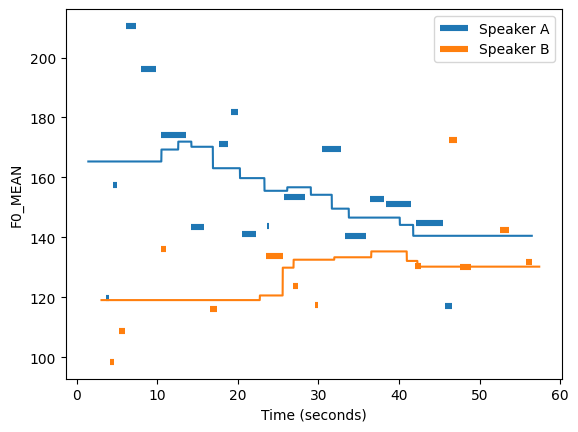

In [10]:
from entrainment_metrics.continuous import plot_time_series

plot_time_series(
    time_series_a=time_series_A, time_series_a_name="Speaker A",
    time_series_b=time_series_B, time_series_b_name="Speaker B",            
)

Finally, it may be useful to note that the `predict()` method can accept both floats (time points) and a list of floats (either a Python list or a NumPy array). Additionaly, there is another method that simplifies the task of predicting over a time interval: `predict_interval()`.

For example:

In [11]:
import numpy as np

float_prediction = time_series_A.predict(30.0)

array_prediction = time_series_A.predict(np.arange(10.0, 11.0, 0.05))

interval_prediction: np.ndarray = time_series_A.predict_interval(
    start=10.0,
    end=11.0,
    granularity=0.05,
)
print(f"Float prediction: {float_prediction}")
print(f"Array prediction: {array_prediction}")
print(f"Interval prediction: {interval_prediction}")

Float prediction: [154.216]
Array prediction: [165.3215   165.3215   165.3215   165.3215   165.3215   165.3215
 165.3215   165.3215   165.3215   165.3215   165.3215   169.304875
 169.304875 169.304875 169.304875 169.304875 169.304875 169.304875
 169.304875 169.304875]
Interval prediction: [165.3215   165.3215   165.3215   165.3215   165.3215   165.3215
 165.3215   165.3215   165.3215   165.3215   165.3215   169.304875
 169.304875 169.304875 169.304875 169.304875 169.304875 169.304875
 169.304875 169.304875 169.304875 169.304875]


### 3.2. Calculating entrainment metrics
Now we are ready to calculate the relevant entrainment metrics between speakers A and B, using the `continuous` module. The metrics available are `proximity`, `convergence`, and `synchrony`, computed in this example for the F0_MEAN feature.

In [12]:
from entrainment_metrics.continuous import calculate_metric

synchrony: float = calculate_metric(
    "synchrony",
    time_series_A,
    time_series_B,
)
print(f"Synchrony: {synchrony}")

proximity: float = calculate_metric(
    "proximity",
    time_series_A,
    time_series_B,
)
print(f"Proximity: {proximity}")

convergence: float = calculate_metric(
    "convergence",
    time_series_A,
    time_series_B,
)
print(f"Convergence: {convergence}")

Synchrony: -0.8605306360595717
Proximity: -27.026408250655138
Convergence: 0.9321914514012148


### 3.3. Speech rate

Another important feature to consider is the *speech rate*. The library provides an extractor named "speech-rate" that estimates the amount of phonemes per second. The following example shows a procedure for this particular feature. Note that the only change is the extractor when pre-calculating a/p features; the rest of the procedure continues in the same manner as before.

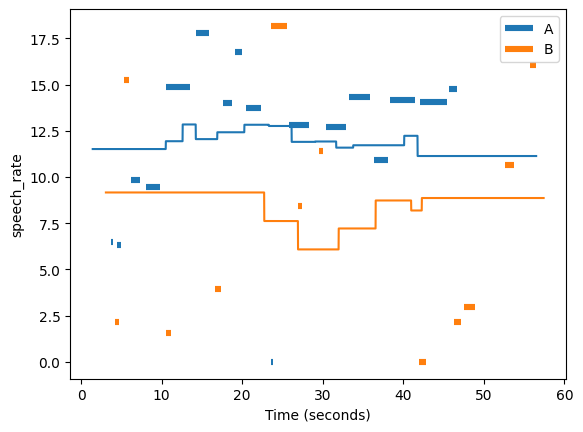

Synchrony: -0.7741040594186978
Proximity: -3.3353540456441717
Convergence: 0.12762816598806662


In [13]:
from entrainment_metrics.continuous import plot_time_series, TimeSeries, calculate_metric

# Extract speech-rate feature from all IPUs.
for ipu in ipusA:
    ipu.calculate_features(
        audio_file="data/test-A.wav",
        extractor="speech-rate",
    )
for ipu in ipusB:
    ipu.calculate_features(
        audio_file="data/test-B.wav",
        extractor="speech-rate",
    )

# Compute time-series for each speaker.
time_series_A: TimeSeries = TimeSeries(
   interpausal_units=ipusA,
   feature="speech_rate",
   method='knn',
   k=8,
)
time_series_B: TimeSeries = TimeSeries(
   interpausal_units=ipusB,
   feature="speech_rate",
   method='knn',
   k=8,
)

# Visualize the time series.
plot_time_series(
            time_series_a=time_series_A,
            time_series_b=time_series_B,
            time_series_a_name="A",
            time_series_b_name="B",
        )

# Compute and print the 3 entrainment metrics for speech-rate.
synchrony: float = calculate_metric(
    "synchrony",
    time_series_A,
    time_series_B,
)
print(f"Synchrony: {synchrony}")

proximity: float = calculate_metric(
    "proximity",
    time_series_A,
    time_series_B,
)
print(f"Proximity: {proximity}")

convergence: float = calculate_metric(
    "convergence",
    time_series_A,
    time_series_B,
)
print(f"Convergence: {convergence}")

****
Copyright 2023 - Universidad Torcuato Di Tella - Laboratorio de Inteligencia Artificial
